In [1]:
import numpy as np
import cv2
from PIL import Image
import time

from triplerecovery import bits, utils, embed, authenticate, recover

In [2]:
key = "this is key"
ekey = "this is key"

In [3]:
imagepath = './cat.jpg'

start_t = time.time()

imarr=np.array(Image.open(imagepath).convert('L'))
imread_t = time.time()

lookup = np.array([[0, 7, 13, 10],
                    [1, 6, 12, 11],
                    [4, 2, 9, 15],
                    [5, 3, 8, 14]], dtype=np.uint8)

# make recoverybits
recovery_bits = bits.recovery .make(imarr, lookup, key)
lla = bits.recovery.embed(imarr, recovery_bits)
hashes = bits.authentication.make(lla)

# embedding
ER = embed(imarr, lookup, key=key)
embedded = ER.imarr.copy()
# authenticate
# AU = authenticate(embedded)

# extract recoverybits
extracted_bits = bits.recovery.extract(embedded, ekey)
# extract hashes
exthashes = bits.authentication.extract(embedded)

startx = 200
starty = 200
width = 10
height = 10

for i in range(width):
    for j in range(height):
        embedded[startx+i][starty+j] = 0
        
startx = 400
starty = 400
width = 200
height = 200

for i in range(width):
    for j in range(height):
        embedded[startx+i][starty+j] = 0

    # authenticate
AU = authenticate(embedded)



In [4]:
# RE = recover(embedded, lookup, key=ekey, interpolation=cv2.INTER_NEAREST)

   

In [5]:
imarr=embedded.copy()

In [6]:
from triplerecovery import blocks, authenticate, bits

In [7]:
# extracting the recovery bits
recovery_bits = bits.recovery.extract(imarr, key)
# extracting the auth bits
tempred = authenticate(imarr).tempred
interpolation=cv2.INTER_NEAREST

In [8]:
lookup = np.array([
        [0, 7, 13, 10],
        [1, 6, 12, 11],
        [4, 2, 9, 15],
        [5, 3, 8, 14]], dtype=np.uint8)

start_t = time.time()

recoveredarr = imarr.copy()

# only do if any of the blocks are tempred
if np.any(tempred):

    # converting the image to 16x16 blocks
    # making 16 main blocks
    # size of single main block S= M/sqrt(16) X T=N/sqrt(16)
    # e.g for lena the 512x512 the partner blocks size would be 16 blocks each with size (512x512)/(4x4) = 128x128
    mainblock_shape = (int(imarr.shape[0]/4), int(imarr.shape[1]/4))
    mainblocks = blocks.make(imarr.copy(), mainblock_shape)

    # here the main blocks are like this index.
    # 1st index is the block number.
    # 2nd index is the channel (RGB) or 0 in Grey.
    # 3rd and 4th are for indexing the block.

    # Making 16x16 for Step 8
    # Dividing the main blocks to 16x16 blocks
    # Total blocks = SxT/16x16 = 128x128/16x16 = 64 Blocks

    b16x16_shape = (16, 16)
    # reshaping because we needed that shape
    b16x16 = mainblocks.reshape(
        *mainblocks.shape[:-2],
        int((mainblock_shape[0]*mainblock_shape[1]) /
            (b16x16_shape[0]*b16x16_shape[1])),
        b16x16_shape[0], b16x16_shape[1]).copy()

    for i in range(mainblocks.shape[0]):
        b16x16[i][0] = blocks.make(mainblocks[i][0], b16x16_shape,
                                    addChannel=False)

    for partner in range(lookup.shape[0]):  # A,B,C,D
        for id in range(lookup.shape[1]):  # A1,A2,A3.....D4 etc
            # check if this is tempred
            if np.any(tempred[lookup[partner, id]]):
                # this mainblock is tempred, so we need to recover it
                # but which 16x16 block is tempred?

                # get the partner block of this id also the id it sits
                partner_block = -1, -1
                for i in range(lookup[partner].shape[0]):
                    # if this id isn't tempred, we can stop
                    if i != id and not np.any(tempred[lookup[partner, i]]):
                        partner_block = partner, i
                        break

                if partner_block == (-1, -1):
                    print(
                        "Could not find partner block for {} {}".format(partner, id))
                    continue

                # get recovery bits of this id
                # get index of this id in the partner block
                idx = id
                if partner_block[1] < id:
                    idx -= 1

                # now we have partner_block, so we can recover it
                # get the recovery bits of this partner block
                recovery_bits_partner = recovery_bits[lookup[partner_block],
                                                        idx*recovery_bits.shape[1]//3:idx*recovery_bits.shape[1]//3+recovery_bits.shape[1]//3]

                # now we have recovrey bits the exact partner block
                # but these are in binary, so we need to convert them to uint
                recovery_decimals = np.packbits(recovery_bits_partner)

                # these recovery bits are for all the main blocks 4x4
                # but we are going to replace only the tempred 16x16

                # shaping these recovery bits to the 16x16 blocks
                _zoomshape = int(
                    imarr.shape[0]/(4*4)), int(imarr.shape[1]/(4*4))
                r16x16 = blocks.make(cv2.resize(
                    recovery_decimals.reshape(
                        _zoomshape), (_zoomshape[1]*4, _zoomshape[0]*4),
                    interpolation=interpolation),
                    b16x16_shape, addChannel=False
                )

                # now we repace which ever 16x16 block is tempred
                for i in range(tempred[lookup[partner, id]].shape[0]):
                    if tempred[lookup[partner, id], i]:
                        # means this 16x16 block is tempred
                        b16x16[lookup[partner, id], 0, i] = r16x16[i]

    # combining the 16x16 blocks to the main blocks
    # merging 16x16
    cmainblocks = mainblocks.copy()
    for i in range(cmainblocks.shape[0]):
        cmainblocks[i][0] = blocks.combine(
            b16x16[i][0], mainblock_shape, blockshape=b16x16_shape, channel=False)

    # merging main blocks to main image
    recoveredarr = blocks.combine(cmainblocks.copy(), imarr.shape,
                                    mainblock_shape).reshape(imarr.shape)

In [9]:
imarr.shape

(1024, 1600)

In [10]:
_zoomshape

(64, 100)

In [11]:
320//16, 512//16, 320//4, 512//4

(20, 32, 80, 128)

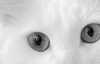

In [12]:
Image.fromarray(recovery_decimals.reshape(_zoomshape))

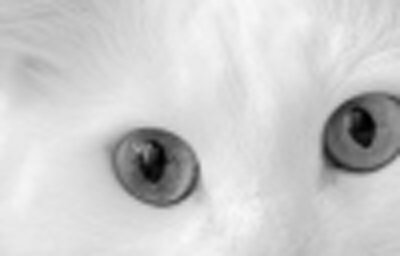

In [13]:
Image.fromarray(cv2.resize(
                    recovery_decimals.reshape(
                        _zoomshape), (_zoomshape[1]*4, _zoomshape[0]*4),
                    interpolation=cv2.INTER_CUBIC))

In [14]:
cv2.resize(
                    recovery_decimals.reshape(
                        _zoomshape), (_zoomshape[0]*4, _zoomshape[1]*4),
                    interpolation=interpolation)

array([[197, 197, 197, ..., 203, 199, 199],
       [197, 197, 197, ..., 203, 199, 199],
       [197, 197, 197, ..., 203, 199, 199],
       ...,
       [221, 221, 221, ..., 201, 204, 204],
       [221, 221, 221, ..., 201, 204, 204],
       [221, 221, 221, ..., 201, 204, 204]], dtype=uint8)

In [15]:
_zoomshape

(64, 100)

In [16]:
recovery_decimals.shape

(6400,)

In [17]:
RE=recoveredarr.copy()

In [18]:
print("Time: ", time.time() - start_t)
print("RE sum: ", (recovery_bits != extracted_bits).sum())
print("RE hash sum: ", (hashes != exthashes).sum())
print("RE hash emb: ", (RE != embedded).sum())
print("PSNR: ", utils.psnr(embedded, imarr))
print("PSNR recoverd: ", utils.psnr(RE, imarr))

Time:  0.6562600135803223
RE sum:  37673
RE hash sum:  0
RE hash emb:  43730
PSNR:  100
PSNR recoverd:  43.367327456810585


In [19]:
# [imarr, imarr2, imarr3, imarr4, imarr5]= [imarr, ER.imarr, embedded, RE.imarr, AU.maskarr]
# cv2.imshow("Original", imarr)
# cv2.imshow("Embedded", imarr2)
# cv2.imshow("Edited", imarr3)
# cv2.imshow("Recovered", imarr4)
# cv2.imshow("MASK", imarr5)

# cv2.waitKey(0)

In [20]:
tempred.sum()

173

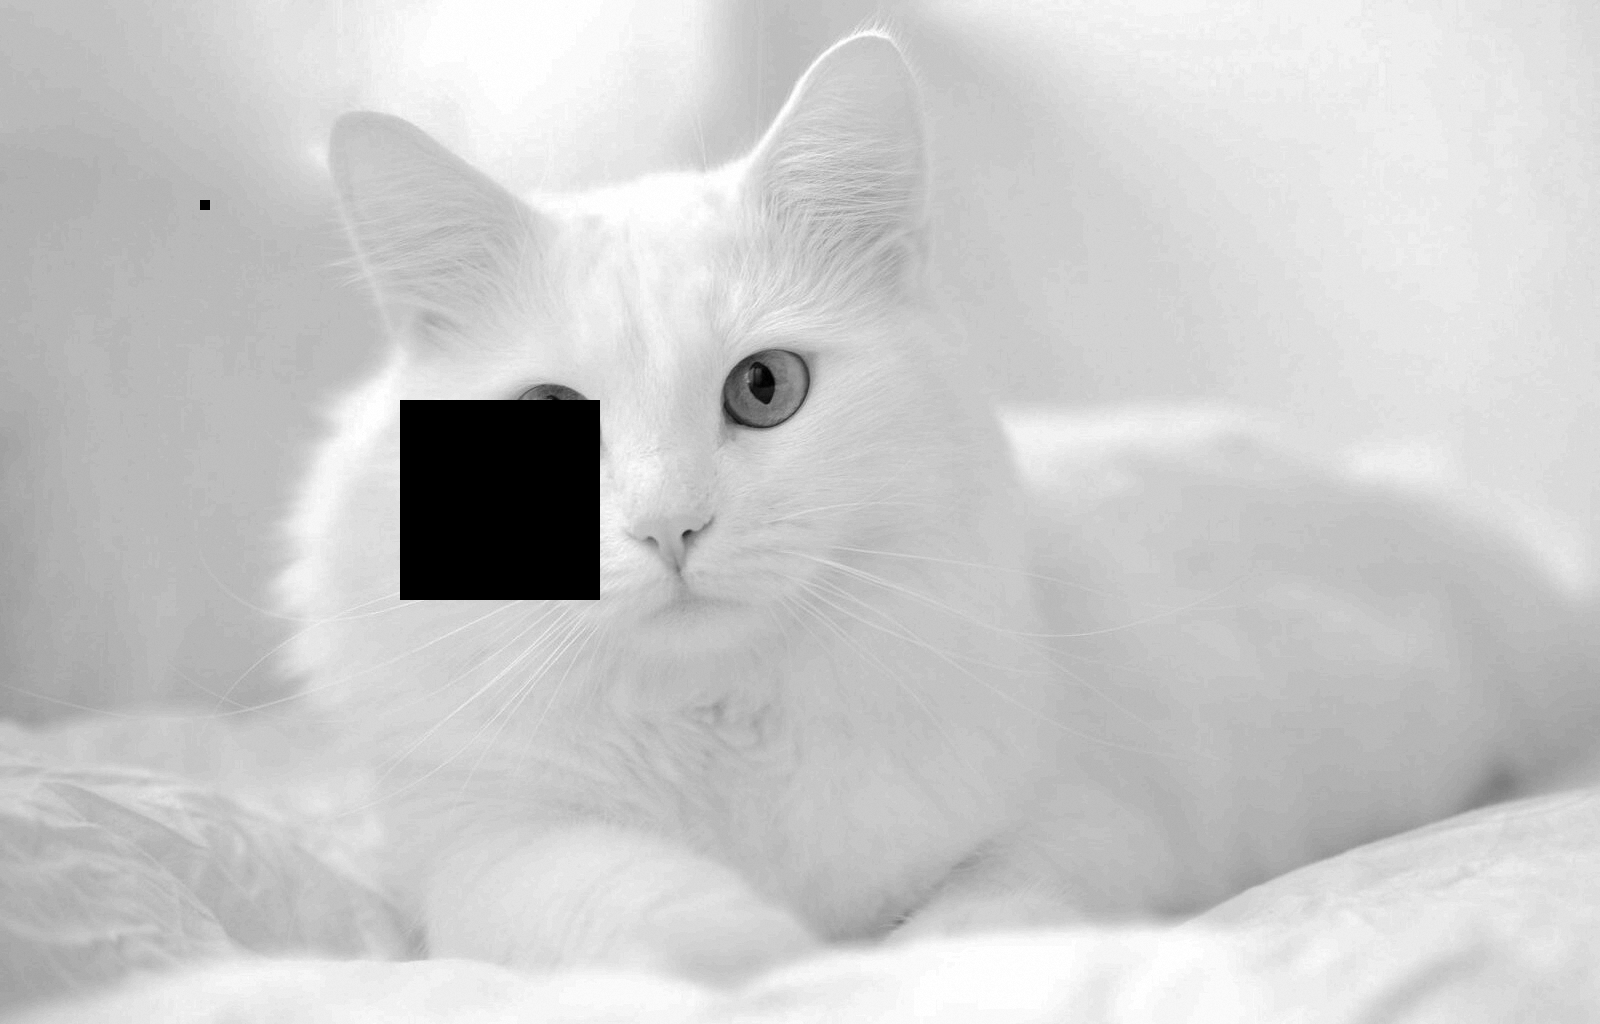

In [21]:
Image.fromarray(embedded)

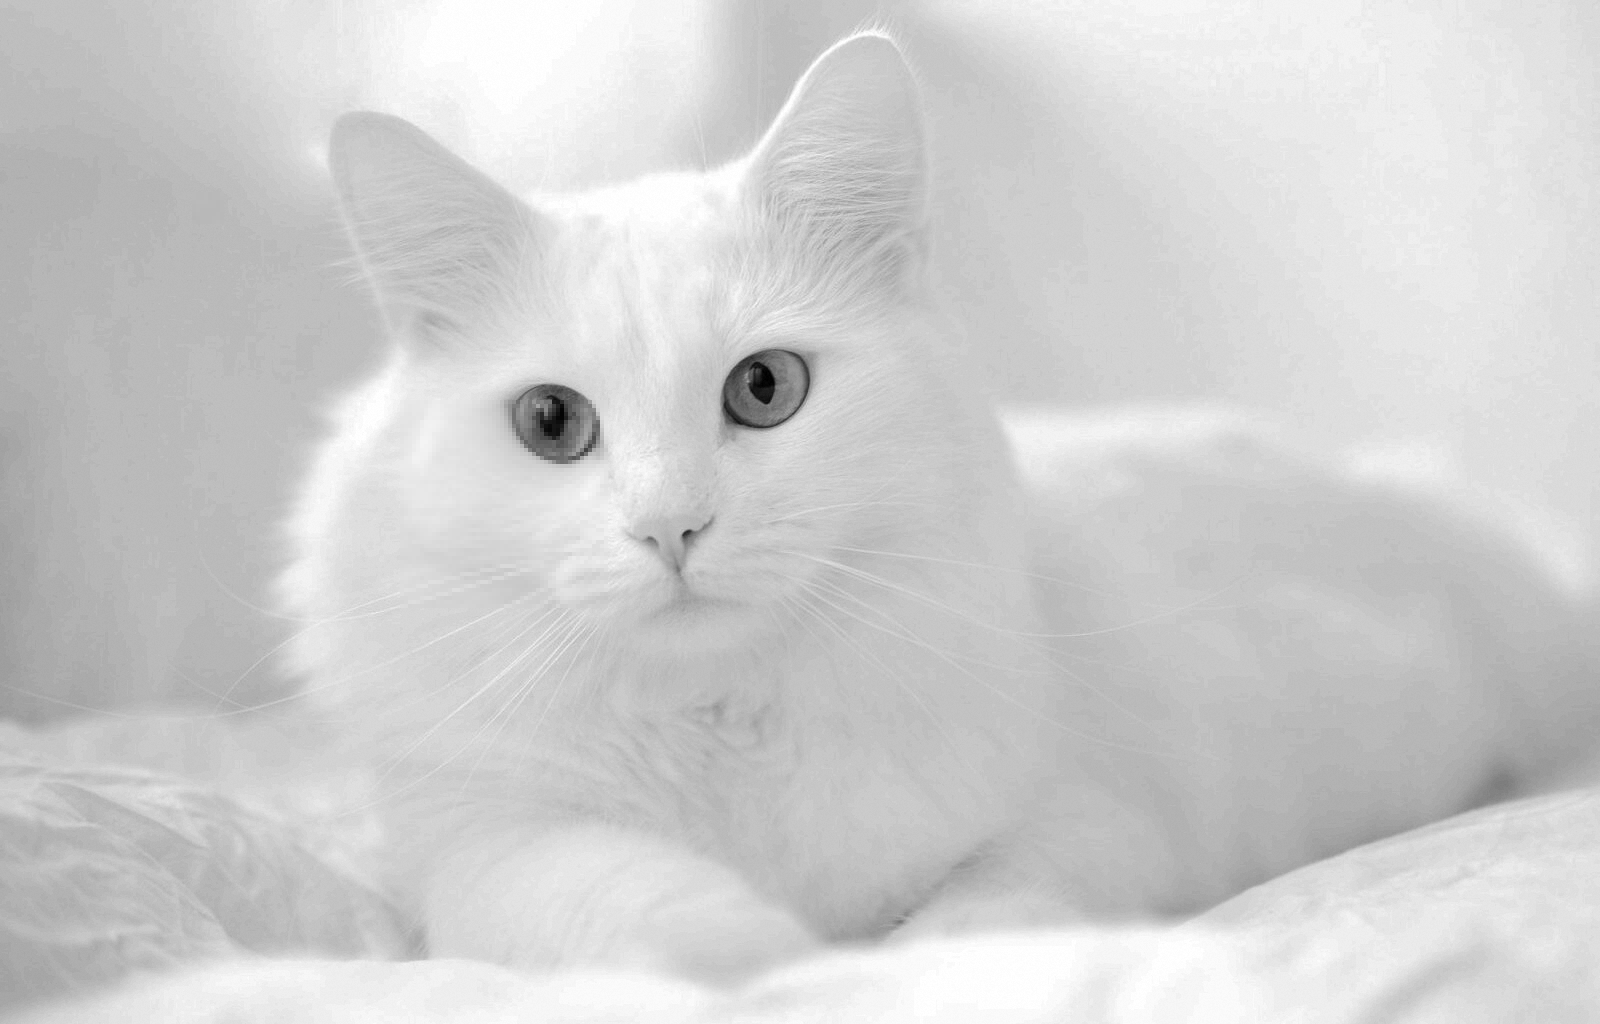

In [22]:
Image.fromarray(RE)